# Block [1-4]
To initiate the prediction process, we will import the pre-constructed dataset and remove any redundant columns to prepare it for prediction.

In [1]:
# Importing neccessary libraries for prediction and set logs to only show error messages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers

In [2]:
#Read and trim the prediction dataset prepared in previous step
source = pd.read_csv('prediction.csv')
dataset = source.copy()
#Remove Date From dataset
dataset.drop(['Date' ], axis=1 ,inplace=True)
#Custom drop list to be removed from dataframe. You can add or remove columns here based on your need
drop_list = [
    'close',
    'open',
    'high',
    'low',
    'sma9',
    'sma20',
    'sma200',
]
dataframe = dataset.drop(drop_list, axis=1)

In [3]:
dataframe

,volume,sma200_4h,diff_sma9,diff_sma20,diff_sma200,diff_sma200_4h,diff_sma9_sma20,target_long,target_short
0,2311.811442,21657.24225,0.004314,0.004921,0.106021,0.338819,0.000604,1,0
1,5403.068447,21657.24225,0.014664,0.018526,0.120602,0.357975,0.003807,1,0
2,2384.231552,21657.24225,0.004836,0.010482,0.111214,0.348032,0.005619,1,0
3,1461.345068,21657.24225,0.006155,0.013164,0.113189,0.351899,0.006966,1,0
4,2038.046776,21714.10715,0.002924,0.010640,0.109774,0.345683,0.007693,1,0
...,...,...,...,...,...,...,...,...,...
3620,1697.834604,47450.29380,-0.003891,0.017405,-0.004846,-0.227085,0.021379,1,0
3621,1483.171068,47450.29380,0.002632,0.021532,0.001693,-0.221658,0.018850,1,0
3622,2322.342409,47450.29380,0.000708,0.017020,-0.000158,-0.222782,0.016301,1,0
3623,2649.154165,47450.29380,0.008945,0.023449,0.009459,-0.214888,0.014376,1,0


In [4]:
# Count the number of data
print('Prediction total count: ', len(dataframe))
print('Prediction target long: ', sum(dataframe.target_long))
print('Prediction traget short: ', sum(dataframe.target_short))

Prediction total count:  3625
Prediction target long:  1657
Prediction traget short:  937


# Block [5-10]
Defining the tensorflow datasets and preparing the feature layer

In [5]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle, batch_size, trg):
  dataframe = dataframe.copy()
  if trg == "long":
    labels = dataframe.pop('target_long')
  else:
    labels = dataframe.pop('target_short')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [6]:
batch_size = 32 # A small batch sized is used for demonstration purposes
predict_ds_long = df_to_dataset(dataframe, shuffle=False, batch_size=batch_size , trg = "long")
predict_ds_short = df_to_dataset(dataframe, shuffle=False, batch_size=batch_size , trg = "short")

In [7]:
#Read Bound json files
import json
long_bound_file = open("long_bound.json", "r")
long_bound = json.load(long_bound_file)
short_bound_file = open("short_bound.json", "r")
short_bound = json.load(short_bound_file)

In [8]:
#Define numerical and bucketized features

#diffsma9
long_diff_sma9 = feature_column.numeric_column('diff_sma9')
short_diff_sma9 = feature_column.numeric_column('diff_sma9')

#diff_sma200
diff_sma200 = feature_column.numeric_column('diff_sma200')
long_diff_sma200_buckets = feature_column.bucketized_column(diff_sma200, boundaries=long_bound['diff_sma200'])
short_diff_sma200_buckets = feature_column.bucketized_column(diff_sma200, boundaries=short_bound['diff_sma200'])

#diff_sma200_4h
diff_sma200_4h = feature_column.numeric_column('diff_sma200_4h')
long_diff_sma200_4h_buckets = feature_column.bucketized_column(diff_sma200_4h, boundaries=long_bound['diff_sma200_4h'])
short_diff_sma200_4h_buckets = feature_column.bucketized_column(diff_sma200_4h, boundaries=short_bound['diff_sma200_4h'])

#diff_sma9_sma20
diff_sma9_sma20 = feature_column.numeric_column('diff_sma9_sma20')
long_diff_sma9_sma20_buckets = feature_column.bucketized_column(diff_sma9_sma20, boundaries=long_bound['diff_sma9_sma20'])
short_diff_sma9_sma20_buckets = feature_column.bucketized_column(diff_sma9_sma20, boundaries=short_bound['diff_sma9_sma20'])

In [9]:
#Define feature columns

feature_columns_long = []
feature_columns_long.append(long_diff_sma9)
feature_columns_long.append(long_diff_sma200_buckets)
feature_columns_long.append(long_diff_sma200_4h_buckets)
feature_columns_long.append(long_diff_sma9_sma20_buckets)

feature_columns_short = []
feature_columns_short.append(short_diff_sma9)
feature_columns_short.append(short_diff_sma200_buckets)
feature_columns_short.append(short_diff_sma200_4h_buckets)
feature_columns_short.append(short_diff_sma9_sma20_buckets)

In [10]:
#Define feature layer

feature_layer_long = tf.keras.layers.DenseFeatures(feature_columns_long)
feature_layer_short = tf.keras.layers.DenseFeatures(feature_columns_short)

# Block [11-17]
Load models and predict the long and short targets

In [11]:
#Import long model
import crossover_long_model
model_long = crossover_long_model.long_model(feature_layer_long)
model_long

In [12]:
#import short model
import crossover_short_model
model_short = crossover_short_model.short_model(feature_layer_short)
model_short

In [13]:
#load models
print("---load model---")
model_long.load_weights(os.path.join("model_files", "crossover_long"))
model_short.load_weights(os.path.join("model_files", "crossover_short"))

---load model---


In [14]:
#Evaluate long model on test dataset
print(sum(dataframe.target_long), '#target long')
loss_long, mae_long = model_long.evaluate(predict_ds_long)

1657 #target long
114/114 [==============================] - 1s 2ms/step - loss: 0.2226 - true_positives: 1602.0000


In [15]:
#Evaluate short model on test dataset
print(sum(dataframe.target_short), '#target short')
loss_short, mae_short = model_short.evaluate(predict_ds_short)

937 #target short
114/114 [==============================] - 1s 2ms/step - loss: 0.2903 - true_positives_1: 750.0000


In [16]:
#Predict long
predicted_long = model_long.predict(predict_ds_long)
predicted_long

114/114 [==============================] - 0s 2ms/step


array([[0.95709556],
       [0.97254753],
       [0.98455685],
       ...,
       [0.8118315 ],
       [0.9235514 ],
       [0.91441643]], dtype=float32)

In [17]:
#Predict short
predicted_short = model_short.predict(predict_ds_short)
predicted_short

114/114 [==============================] - 0s 2ms/step


array([[5.9847796e-05],
       [5.9627790e-05],
       [1.2067289e-04],
       ...,
       [3.3829824e-04],
       [2.1129243e-04],
       [2.1025144e-04]], dtype=float32)

# Block[18-23]
Save predictions to a new dataframe

In [18]:
#Make a predicted draft of the original dataset to add predicted labels to it
predicted = source.copy()
predicted

,Date,close,open,high,low,volume,sma9,sma20,sma200,sma200_4h,diff_sma9,diff_sma20,diff_sma200,diff_sma200_4h,diff_sma9_sma20,target_long,target_short
0,2021-01-01 00:00:00,28995.13,28923.63,29031.34,28690.17,2311.811442,28870.590000,28853.1485,26215.70440,21657.24225,0.004314,0.004921,0.106021,0.338819,0.000604,1,0
1,2021-01-01 01:00:00,29409.99,28995.13,29470.00,28960.35,5403.068447,28984.966667,28875.0380,26244.80740,21657.24225,0.014664,0.018526,0.120602,0.357975,0.003807,1,0
2,2021-01-01 02:00:00,29194.65,29410.00,29465.26,29120.03,2384.231552,29054.153333,28891.8200,26272.75530,21657.24225,0.004836,0.010482,0.111214,0.348032,0.005619,1,0
3,2021-01-01 03:00:00,29278.40,29195.25,29367.00,29150.02,1461.345068,29099.281111,28897.9775,26301.36275,21657.24225,0.006155,0.013164,0.113189,0.351899,0.006966,1,0
4,2021-01-01 04:00:00,29220.31,29278.41,29395.00,29029.40,2038.046776,29135.112222,28912.6775,26329.95435,21714.10715,0.002924,0.010640,0.109774,0.345683,0.007693,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3620,2021-05-31 20:00:00,36675.06,36865.75,36980.76,36557.30,1697.834604,36818.311111,36047.6645,36853.66570,47450.29380,-0.003891,0.017405,-0.004846,-0.227085,0.021379,1,0
3621,2021-05-31 21:00:00,36932.55,36677.85,37087.30,36623.01,1483.171068,36835.594444,36154.0725,36870.11810,47450.29380,0.002632,0.021532,0.001693,-0.221658,0.018850,1,0
3622,2021-05-31 22:00:00,36879.23,36932.55,37250.00,36835.85,2322.342409,36853.144444,36262.0340,36885.05470,47450.29380,0.000708,0.017020,-0.000158,-0.222782,0.016301,1,0
3623,2021-05-31 23:00:00,37253.81,36879.23,37499.00,36800.93,2649.154165,36923.524444,36400.2460,36904.73330,47450.29380,0.008945,0.023449,0.009459,-0.214888,0.014376,1,0


In [19]:
#Assign predicted labels to each row of dataframe base on the probability provided by models
predicted['probability_long'] = np.array(predicted_long)
predicted['probability_short'] = np.array(predicted_short)

predicted['predicted_long'] = np.select([(predicted.probability_long > 0.5)], [1] , 0)
predicted['predicted_short'] = np.select([(predicted.probability_short > 0.5)], [1] , 0)

predicted

,Date,close,open,high,low,volume,sma9,sma20,sma200,sma200_4h,...,diff_sma20,diff_sma200,diff_sma200_4h,diff_sma9_sma20,target_long,target_short,probability_long,probability_short,predicted_long,predicted_short
0,2021-01-01 00:00:00,28995.13,28923.63,29031.34,28690.17,2311.811442,28870.590000,28853.1485,26215.70440,21657.24225,...,0.004921,0.106021,0.338819,0.000604,1,0,0.957096,0.000060,1,0
1,2021-01-01 01:00:00,29409.99,28995.13,29470.00,28960.35,5403.068447,28984.966667,28875.0380,26244.80740,21657.24225,...,0.018526,0.120602,0.357975,0.003807,1,0,0.972548,0.000060,1,0
2,2021-01-01 02:00:00,29194.65,29410.00,29465.26,29120.03,2384.231552,29054.153333,28891.8200,26272.75530,21657.24225,...,0.010482,0.111214,0.348032,0.005619,1,0,0.984557,0.000121,1,0
3,2021-01-01 03:00:00,29278.40,29195.25,29367.00,29150.02,1461.345068,29099.281111,28897.9775,26301.36275,21657.24225,...,0.013164,0.113189,0.351899,0.006966,1,0,0.984561,0.000121,1,0
4,2021-01-01 04:00:00,29220.31,29278.41,29395.00,29029.40,2038.046776,29135.112222,28912.6775,26329.95435,21714.10715,...,0.010640,0.109774,0.345683,0.007693,1,0,0.984551,0.000121,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3620,2021-05-31 20:00:00,36675.06,36865.75,36980.76,36557.30,1697.834604,36818.311111,36047.6645,36853.66570,47450.29380,...,0.017405,-0.004846,-0.227085,0.021379,1,0,0.890098,0.000339,1,0
3621,2021-05-31 21:00:00,36932.55,36677.85,37087.30,36623.01,1483.171068,36835.594444,36154.0725,36870.11810,47450.29380,...,0.021532,0.001693,-0.221658,0.018850,1,0,0.812024,0.000338,1,0
3622,2021-05-31 22:00:00,36879.23,36932.55,37250.00,36835.85,2322.342409,36853.144444,36262.0340,36885.05470,47450.29380,...,0.017020,-0.000158,-0.222782,0.016301,1,0,0.811831,0.000338,1,0
3623,2021-05-31 23:00:00,37253.81,36879.23,37499.00,36800.93,2649.154165,36923.524444,36400.2460,36904.73330,47450.29380,...,0.023449,0.009459,-0.214888,0.014376,1,0,0.923551,0.000211,1,0


In [20]:
#Set date in a correct format as dataframe index for future purposes
df_predicted = predicted.copy()
df_predicted['Date'] = pd.to_datetime(predicted['Date'], format='%Y-%m-%d %H:%M:%S')
df_predicted.set_index('Date', inplace=True)
df_predicted

,close,open,high,low,volume,sma9,sma20,sma200,sma200_4h,diff_sma9,diff_sma20,diff_sma200,diff_sma200_4h,diff_sma9_sma20,target_long,target_short,probability_long,probability_short,predicted_long,predicted_short
Date,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,28995.13,28923.63,29031.34,28690.17,2311.811442,28870.590000,28853.1485,26215.70440,21657.24225,0.004314,0.004921,0.106021,0.338819,0.000604,1,0,0.957096,0.000060,1,0
2021-01-01 01:00:00,29409.99,28995.13,29470.00,28960.35,5403.068447,28984.966667,28875.0380,26244.80740,21657.24225,0.014664,0.018526,0.120602,0.357975,0.003807,1,0,0.972548,0.000060,1,0
2021-01-01 02:00:00,29194.65,29410.00,29465.26,29120.03,2384.231552,29054.153333,28891.8200,26272.75530,21657.24225,0.004836,0.010482,0.111214,0.348032,0.005619,1,0,0.984557,0.000121,1,0
2021-01-01 03:00:00,29278.40,29195.25,29367.00,29150.02,1461.345068,29099.281111,28897.9775,26301.36275,21657.24225,0.006155,0.013164,0.113189,0.351899,0.006966,1,0,0.984561,0.000121,1,0
2021-01-01 04:00:00,29220.31,29278.41,29395.00,29029.40,2038.046776,29135.112222,28912.6775,26329.95435,21714.10715,0.002924,0.010640,0.109774,0.345683,0.007693,1,0,0.984551,0.000121,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 20:00:00,36675.06,36865.75,36980.76,36557.30,1697.834604,36818.311111,36047.6645,36853.66570,47450.29380,-0.003891,0.017405,-0.004846,-0.227085,0.021379,1,0,0.890098,0.000339,1,0
2021-05-31 21:00:00,36932.55,36677.85,37087.30,36623.01,1483.171068,36835.594444,36154.0725,36870.11810,47450.29380,0.002632,0.021532,0.001693,-0.221658,0.018850,1,0,0.812024,0.000338,1,0
2021-05-31 22:00:00,36879.23,36932.55,37250.00,36835.85,2322.342409,36853.144444,36262.0340,36885.05470,47450.29380,0.000708,0.017020,-0.000158,-0.222782,0.016301,1,0,0.811831,0.000338,1,0


In [21]:
#Preparing the dataframe to plot predicted long and short labels
_from = '2021-01-01 00:00:00'
_to = '2021-04-01 00:00:00'
df_plot = df_predicted.loc[_from:_to,:].copy()
df_plot['long_labeled'] = np.select([(df_plot.predicted_long == 1)], [df_plot.close] , np.nan)
df_plot['short_labeled'] = np.select([(df_plot.predicted_short == 1)], [df_plot.close] , np.nan)

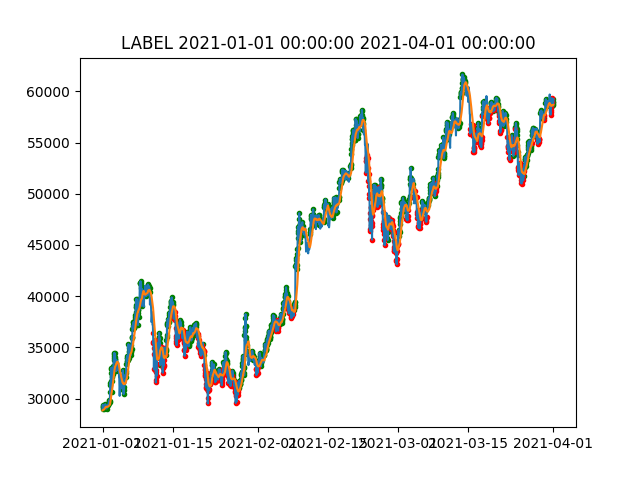

In [22]:
#Visualize a part of predicted dataframe
%matplotlib widget
import matplotlib.pyplot as plt

fig = plt.figure()
plt.title('LABEL ' + _from + ' ' +  _to)
plt.plot(df_plot.index.values,df_plot.close)
plt.plot(df_plot.index.values,df_plot.sma20)
plt.scatter(df_plot.index.values,df_plot.long_labeled,marker="." , color="g" )
plt.scatter(df_plot.index.values,df_plot.short_labeled,marker="." , color="r" )
plt.show()

In [23]:
#Save prediction files for further use
df_predicted.to_csv('predicted.csv', index = True, header=True)